* terminated 했을 때 한정으로 다음 state의 max q값을 더하면 안됨. 더하면 정확도 0.1정도로 떨어짐 (0.1은 거의 랜덤으로 돌렸을 때와 같은 성능)
    * terminated할 가능성이 있는 5, 7, 11, 12, 15 state의 q값을 0으로 고정해도 안됨
    * non deterministic world에서 q table을 썼을 때나 deterministic world에서 q table + learning rate를 썼을 때는 마지막에 다음 state의 max q값을 더해도 괜찮았는데 차이를 모르겠음
* 초기에 q table을 0으로만 초기화하면 정확도 0으로 고정됨. 아예 학습이 안되고 한 번도 보상을 받지 못함
    * action을 고를 때 q값이 가장 큰 것이 여러개일 경우 그 중에서 무작위로 뽑는 전략을 적용하면 파훼할 수 있음
* decaying e-greedy: 수렴이 빠름
* 일반 e-greedy: 수렴이 조금 빠르지만 후반에는 성능을 떨어뜨리면서 방해됨
* non e-greedy: 수렴이 느림
* one hot벡터와의 행렬곱은 인덱싱으로 바꿀 수 있음

In [97]:
import gymnasium
import numpy as np
import torch

In [98]:
env = gymnasium.make('FrozenLake-v1')

In [99]:
q = torch.empty([env.observation_space.n, env.action_space.n]).uniform_(0, 0.01).requires_grad_()
# for i in [5, 7, 11, 12, 15]:
#     q[i, :].zero_()
# q.requires_grad_()

In [100]:
discount = 0.99
lr = 0.1
num_episodes = 2000

In [101]:
criterion = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD([q], lr=lr)

In [102]:
rewards = []
steps = []
for i in range(num_episodes):
    u, info = env.reset()
    reward = 0
    step = 0
    while True:
        u_q = q[u]
        e = 1 / (10 + i / 50)
        if np.random.random() < e:
            action = env.action_space.sample()
        else:
            a = u_q.cpu().detach()
            action = np.random.choice(np.flatnonzero(a == a.max())) #torch.argmax(u_q).cpu().detach().item()
        v, r, terminated, truncated, info = env.step(action)
        v_q = q[v]
        reward += r
        step += 1
        target_q = u_q.clone()
        if terminated:
            target_q[action] = r
        else:
            target_q[action] = r + discount * torch.max(v_q)
        loss = criterion(target_q, u_q)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        u = v
        if terminated or truncated:
            break
    rewards.append(reward)
    steps.append(step)

0.4305


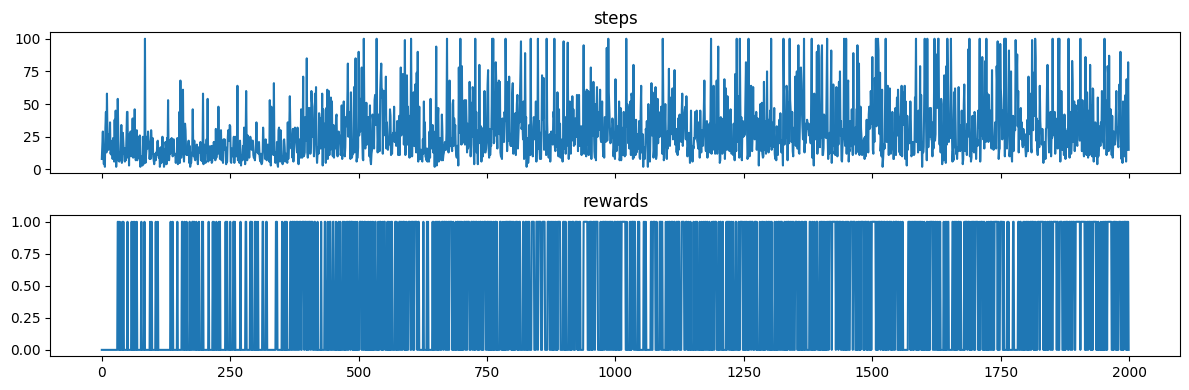

In [103]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12, 4))
axes[0].set_title('steps')
axes[0].plot(steps)
axes[1].set_title('rewards')
axes[1].plot(rewards)
plt.tight_layout()
print(np.mean(rewards))

In [104]:
q

tensor([[4.8963e-01, 5.6254e-01, 4.8361e-01, 5.0664e-01],
        [3.1466e-01, 1.0702e-01, 1.2375e-01, 5.4606e-01],
        [3.0381e-01, 3.2499e-01, 2.3449e-01, 2.2850e-01],
        [1.4844e-01, 2.2375e-01, 1.7162e-02, 1.3496e-01],
        [5.6722e-01, 3.8393e-01, 4.7490e-01, 2.7991e-01],
        [1.5061e-03, 9.6300e-05, 9.5524e-04, 4.2599e-06],
        [2.6430e-01, 1.5038e-01, 3.9111e-01, 1.6766e-01],
        [6.2021e-03, 4.5537e-03, 8.5363e-03, 8.5604e-04],
        [5.1577e-01, 3.1715e-01, 4.2040e-01, 5.8004e-01],
        [1.5671e-01, 5.9641e-01, 3.5903e-01, 3.7314e-01],
        [5.5774e-01, 3.3421e-01, 2.6572e-01, 2.4056e-01],
        [9.5105e-04, 7.8362e-03, 8.4519e-03, 3.7555e-03],
        [9.7677e-03, 8.5692e-03, 5.2088e-03, 1.2444e-03],
        [3.3659e-01, 2.6200e-01, 6.8904e-01, 3.3782e-01],
        [5.5499e-01, 7.7679e-01, 6.4638e-01, 6.8025e-01],
        [8.0172e-03, 4.9836e-03, 6.7313e-03, 6.1911e-03]], requires_grad=True)